In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from ast import literal_eval
from glob import glob

%matplotlib inline

In [2]:
cutoffs = [a/10.0 for a in xrange(1,10)]
colnames = ["score"+str(c) for c in cutoffs]
cnum = len(cutoffs)

In [3]:
def score(dataset, cutoffs):
    cols = [col for col in dataset.columns if (col not in ["name", "label"] and "score" not in col)]
    for c in cutoffs:
        name = "score"+str(c)
        dataset[name] = dataset[dataset[cols] >= c][cols].fillna(0).sum(axis=1)

In [4]:
def raw_mean(x, a):
    return a*x

def raw_std(x, a, b):
    return a*(x**b)

In [5]:
method="DeCAF"
#method = "FP2"
#method = "FP3"
#method = "FP4"
#method = "MACCS"

In [6]:
with open(("../data/statistical_model/" + method + ".params")) as f:
    params = literal_eval(f.read())

In [7]:
params

{0.1: {'mean': [0.3035065020795763],
  'std': [0.05021450233503376, 0.9996262098949061]},
 0.2: {'mean': [0.27977805401292777],
  'std': [0.07429864261164147, 1.000029193808274]},
 0.3: {'mean': [0.18959352107040828],
  'std': [0.08297258853122572, 0.9996615040429673]},
 0.4: {'mean': [0.0794863100388481],
  'std': [0.04929852337543983, 0.9978054135368709]},
 0.5: {'mean': [0.02105655079117011],
  'std': [0.019161502541326852, 0.9937496437888661]},
 0.6: {'mean': [0.004183514421797652],
  'std': [0.006615684287016445, 0.9826808055191903]},
 0.7: {'mean': [0.0007247293571456762],
  'std': [0.0020309056566072486, 0.9593770531220707]},
 0.8: {'mean': [0.00012597756061023655],
  'std': [0.0012474506946934694, 0.838067547723973]},
 0.9: {'mean': [1.5209147355417976e-05],
  'std': [0.0008888983916846435, 0.6691710584562793]}}

In [8]:
def normalize(row):
    cutoff = row["cutoff"]
    size = row["size"]
    score = row["score"]
    z_score = ((row["score"] - raw_mean(size, *params[cutoff]["mean"])) /
               raw_std(size, *params[cutoff]["std"]))
    return z_score

In [9]:
def pvalue(z):
    z = np.array(z)
    x = -np.exp(-z * math.pi / math.sqrt(6) - 0.5772156649)
    idx = np.where(z < 28)[0]
    res = np.empty_like(z)
    res = -(x + (x**2)/2.0 + (x**3)/6.0)
    res[idx] = 1.0 - np.exp(x[idx])
    return res

# Data

In [10]:
targets = []
datasets = {}

In [11]:
for i in glob("../data/results/"+method+"/*tab.bz2"):
    name = i.split('/')[-1].split('.')[0]
    targets.append(name)
    datasets[name] = pd.read_table(i)

In [12]:
len(targets)

73

In [13]:
print targets

['SCN5A', 'CHRM3', 'CRHR1', 'HTR2A', 'CRHR2', 'ESR1', 'PGR', 'MC3R', 'ADORA3', 'SLC6A2', 'TBXA2R', 'BDKRB2', 'AR', 'CCKBR', 'GRIN3A', 'HTR1A', 'PDE3A', 'CACNA1C', 'AGTR1', 'DRD2', 'EDNRB', 'PDE4D', 'ADORA2A', 'BDKRB1', 'DRD4', 'GPR109A', 'ADRA1A', 'ADRB2', 'EDNRA', 'HTR2B', 'DRD3', 'PTGS2', 'HRH3', 'ADRB1', 'HRH2', 'OPRK1', 'HTR2C', 'ADRA2A', 'SLC6A4', 'CACNA1B', 'HRH1', 'MC4R', 'HTR3A', 'AVPR1A', 'CHRM1', 'OPRM1', 'ADRA2C', 'ESR2', 'ADRB3', 'PTGS1', 'NPY2R', 'SLC6A3', 'ADORA1', 'CNR1', 'DRD1', 'CHRNA10', 'MLN', 'CHRM2', 'NR1I2', 'SLC29A1', 'AVPR2', 'NTSR1', 'NR3C1', 'MAOA', 'TACR1', 'GABRA1', 'OPRD1', 'CCKAR', 'KCNH2', 'GIPR', 'ADRA2B', 'GHSR', 'NPY1R']


In [14]:
drug_targets = pd.read_csv("../data/drug_targets.csv", index_col=0)
drug_targets.head()

,drug,target,pred
5,Acebutolol,ADRB2,old
6,Acebutolol,ADRB1,old
9,Acetaminophen,PTGS1,old
17,Acetaminophen,PTGS2,old
40,Acetophenazine,DRD1,old


In [15]:
np.sum(drug_targets["pred"] == "new")

150

In [16]:
np.sum(drug_targets["pred"] == "old")

1079

In [17]:
np.sum(drug_targets["pred"] == "drugbank")

82

In [18]:
trivial = pd.read_csv("../data/trivial_hits.csv", index_col=0)
chemb_low_activity = pd.read_csv("../data/chembl_low_activity_hits.csv", index_col=0)

# Results

## Raw scores

In [19]:
all_data = pd.DataFrame(columns=["target", "drug", "cutoff", "score", "size"])

In [20]:
cutoffs, cnum, method, len(targets)

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 9, 'DeCAF', 73)

In [21]:
for t in targets:
    print t
    score(datasets[t], cutoffs)
    size = datasets[t].shape[1] - cnum - 1
    for i in xrange(cnum):
        col = colnames[i]
        cutoff = cutoffs[i]
        tmp = datasets[t][["name", col]]
        tmp.columns = ["drug", "score"]
        tmp["target"] = t
        tmp["cutoff"] = cutoff
        tmp["size"] = datasets[t].shape[1] - cnum - 1
        all_data = pd.concat([all_data, tmp])

SCN5A
CHRM3
CRHR1
HTR2A
CRHR2
ESR1
PGR
MC3R
ADORA3
SLC6A2
TBXA2R
BDKRB2
AR
CCKBR
GRIN3A
HTR1A
PDE3A
CACNA1C
AGTR1
DRD2
EDNRB
PDE4D
ADORA2A
BDKRB1
DRD4
GPR109A
ADRA1A
ADRB2
EDNRA
HTR2B
DRD3
PTGS2
HRH3
ADRB1
HRH2
OPRK1
HTR2C
ADRA2A
SLC6A4
CACNA1B
HRH1
MC4R
HTR3A
AVPR1A
CHRM1
OPRM1
ADRA2C
ESR2
ADRB3
PTGS1
NPY2R
SLC6A3
ADORA1
CNR1
DRD1
CHRNA10
MLN
CHRM2
NR1I2
SLC29A1
AVPR2
NTSR1
NR3C1
MAOA
TACR1
GABRA1
OPRD1
CCKAR
KCNH2
GIPR
ADRA2B
GHSR
NPY1R


In [22]:
print all_data.shape
all_data.head()

(430992, 5)


,cutoff,drug,score,size,target
0,0.1,Acarbose,22.233594,61.0,SCN5A
1,0.1,Acebutolol,20.908136,61.0,SCN5A
2,0.1,Aceclofenac,25.837062,61.0,SCN5A
3,0.1,Acenocoumarol,22.027414,61.0,SCN5A
4,0.1,Acetaminophen,22.983463,61.0,SCN5A


## Z-scores, p-values, e-values

In [23]:
all_data["z_score"] = all_data.apply(normalize, axis=1)
all_data.head()

,cutoff,drug,score,size,target,z_score
0,0.1,Acarbose,22.233594,61.0,SCN5A,1.216231
1,0.1,Acebutolol,20.908136,61.0,SCN5A,0.782845
2,0.1,Aceclofenac,25.837062,61.0,SCN5A,2.394458
3,0.1,Acenocoumarol,22.027414,61.0,SCN5A,1.148816
4,0.1,Acetaminophen,22.983463,61.0,SCN5A,1.461416


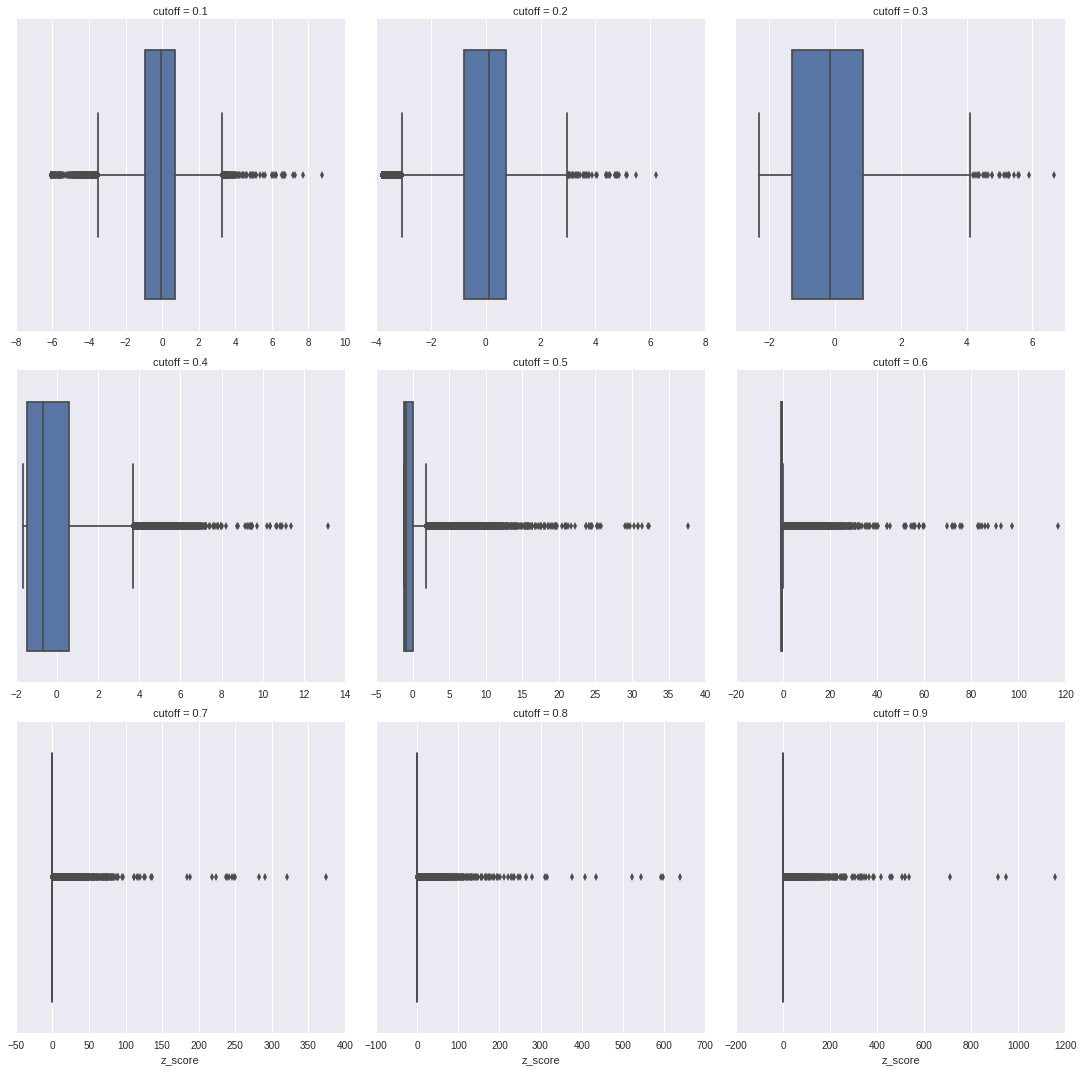

In [24]:
grid_z = sns.FacetGrid(all_data, col="cutoff", size=5, col_wrap=3, sharex=False, sharey=False, legend_out=True)
grid_z = (grid_z.map(sns.boxplot, "z_score").add_legend())
grid_z;

In [25]:
all_data["p_value"] = pvalue(all_data["z_score"])
all_data.head()

,cutoff,drug,score,size,target,z_score,p_value
0,0.1,Acarbose,22.233594,61.0,SCN5A,1.216231,0.111302
1,0.1,Acebutolol,20.908136,61.0,SCN5A,0.782845,0.185937
2,0.1,Aceclofenac,25.837062,61.0,SCN5A,2.394458,0.025701
3,0.1,Acenocoumarol,22.027414,61.0,SCN5A,1.148816,0.120722
4,0.1,Acetaminophen,22.983463,61.0,SCN5A,1.461416,0.082552


In [26]:
N = 73 * 656
N

47888

In [27]:
all_data["e_value"] = all_data["p_value"] * N
all_data.head()

,cutoff,drug,score,size,target,z_score,p_value,e_value
0,0.1,Acarbose,22.233594,61.0,SCN5A,1.216231,0.111302,5330.016529
1,0.1,Acebutolol,20.908136,61.0,SCN5A,0.782845,0.185937,8904.133727
2,0.1,Aceclofenac,25.837062,61.0,SCN5A,2.394458,0.025701,1230.779022
3,0.1,Acenocoumarol,22.027414,61.0,SCN5A,1.148816,0.120722,5781.125067
4,0.1,Acetaminophen,22.983463,61.0,SCN5A,1.461416,0.082552,3953.259373


In [28]:
all_data.to_csv("../data/results/"+method+"_all_results.csv")

## Summary

In [29]:
e_range = np.arange(-10, 1)
e_range

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0])

In [30]:
predictions = {e: {t: set() for t in targets} for e in e_range}

In [31]:
for e in e_range:
    pred = all_data[(all_data["e_value"] <= 10**e)].groupby("target")
    for t, group in pred:
        predictions[e][t] = predictions[e][t] | set(list(group["drug"]))

In [32]:
low_act = {}
for t in targets:
    low_act[t] = set(list(chemb_low_activity[(chemb_low_activity["target"] == t)]["drug"].unique()))

In [33]:
triv = {}
for t in targets:
    triv[t] = set(list(trivial[(trivial["target"] == t)]["drug"].unique()))

In [34]:
known = {}
for t in targets:
    known[t] = (set(list(drug_targets[(drug_targets["target"] == t)]["drug"].unique())) | triv[t] | low_act[t])

In [35]:
summary = pd.DataFrame(columns=["e_value", "target", "pred", "true", "not trivial", "low activity", "false",
                                "not found"])

In [36]:
i = 0
for e in e_range:
    for t in targets:
        pr = predictions[e][t]
        tr = len(pr & known[t])
        nt = len((pr & known[t]) - triv[t])
        la = len(pr & low_act[t])
        f = len(pr - known[t])
        nf = len((known[t] - pr))        
        summary.loc[i] = [10**e, t, len(pr), tr, nt, la, f, nf]
        i += 1

In [37]:
summary.head()

,e_value,target,pred,true,not trivial,low activity,false,not found
0,1.000000e-10,SCN5A,1.0,1.0,0.0,0.0,0.0,19.0
1,1.000000e-10,CHRM3,17.0,14.0,4.0,0.0,3.0,43.0
2,1.000000e-10,CRHR1,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000e-10,HTR2A,17.0,12.0,1.0,0.0,5.0,75.0
4,1.000000e-10,CRHR2,3.0,0.0,0.0,0.0,3.0,0.0


In [38]:
summary.to_csv("../data/results/"+method+"_summary.csv")

In [39]:
summary_e = summary.groupby("e_value").sum()[["pred", "true", "not trivial", "low activity", "false", "not found"]]
summary_e

,pred,true,not trivial,low activity,false,not found
e_value,,,,,,
1.000000e-10,783.0,505.0,136.0,20.0,278.0,1639.0
1.000000e-09,824.0,529.0,142.0,20.0,295.0,1615.0
1.000000e-08,874.0,556.0,151.0,22.0,318.0,1588.0
1.000000e-07,958.0,593.0,158.0,24.0,365.0,1551.0
1.000000e-06,1036.0,621.0,165.0,26.0,415.0,1523.0
1.000000e-05,1143.0,673.0,174.0,27.0,470.0,1471.0
1.000000e-04,1264.0,731.0,185.0,28.0,533.0,1413.0
1.000000e-03,1418.0,789.0,201.0,31.0,629.0,1355.0
1.000000e-02,1610.0,842.0,222.0,36.0,768.0,1302.0


In [40]:
summary_e.to_csv("../data/results/"+method+"_summary_e.csv")